# Preliminary steps

### Import dependencies

In [0]:
import pandas as pd
from pandas.core.common import flatten
import sklearn.metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk import SnowballStemmer as snow

### Load file as a dataframe

In [0]:
file = '/content/RAW_recipes.csv'
df = pd.read_csv(file)

# EDA

### Explore the data

In [33]:
print(f"There are {df.shape[0]} rows (recipes) in the dataframe.")

There are 231637 rows (recipes) in the dataframe.


In [34]:
print('The columns are:') 
print(df.columns)
print(f'\nThere are {df.shape[1]} columns.')

The columns are:
Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

There are 12 columns.


Look at a sample of the data:

In [36]:
df.sample(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
45080,chicken parmesan express,3166,20,1535,1999-10-06,"['30-minutes-or-less', 'time-to-make', 'course...","[698.9, 30.0, 32.0, 34.0, 89.0, 47.0, 27.0]",11,['place the chicken between two sheets of heav...,an easy dish with lots of flavor. it is one of...,"['angel hair pasta', 'boneless skinless chicke...",9
122474,lemon ginger and mint fizz,282319,5,324136,2008-01-29,"['15-minutes-or-less', 'time-to-make', 'course...","[7.9, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",3,"['place ginger beer , lemonade and bitters in ...",good taste magazine november 2006,"['diet ginger beer', 'angostura bitters', 'die...",6
68671,curried rice and fruit salad,63805,65,37779,2003-06-05,"['weeknight', 'time-to-make', 'course', 'main-...","[379.1, 11.0, 86.0, 16.0, 12.0, 14.0, 24.0]",18,"['wash rice until water runs clear', 'drain we...",this rice salad has exotic flavors that make a...,"['basmati rice', 'peanut oil', 'green onion', ...",19


# Preparing the data

## Gluten free recipes

Look for recipes that are Gluten free, ie - do not contain wheat, barley, rye, or oats. 

In [0]:
df_gf = df[(df['description'].str.contains('gluten free') |
           df['description'].str.contains('gluten intolerant') |
           df['ingredients'].str.contains('gluten free') |
           df['ingredients'].str.contains('gluten intolerant') |
           df['name'].str.contains('gluten free') |
           df['name'].str.contains('gluten intolerant') |
           ~ df['ingredients'].str.contains('oat|rye|barley|wheat|flour') 
           )]

In [0]:
print(f"There are {df_gf.shape[0]} gluten free recipes.")

There are 217325 gluten free recipes.


### Subsetting

Take a subset of the data (plus only the relevant features)

In [0]:
df_recipes = df_gf.loc[:,['id', 'name', 'ingredients', 'nutrition']]

Set the index as the recipe unique id

In [40]:
df_recipes = df_recipes.set_index('id')
df_recipes.head()

,name,ingredients,nutrition
id,,,
137739,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed ...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]"
31490,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'egg...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]"
112140,all in the kitchen chili,"['ground beef', 'yellow onions', 'diced tomato...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]"
59389,alouette potatoes,"['spreadable cheese with garlic and herbs', 'n...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]"
44061,amish tomato ketchup for canning,"['tomato juice', 'apple cider vinegar', 'sugar...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]"


### Recipe Nutrition

In [0]:
# preprocessing_nutrition 
df_recipes['nutrition'] = (df_recipes.nutrition
 .str.replace('[', '')
 .str.replace(']', '')
 .str.replace("'", '')
 .str.replace(",", '')
 .str.split())

In [0]:
#create new nutrition columns
df_recipes['calories'] = df_recipes.apply(lambda row: float(row.nutrition[0]), axis=1)
# df_recipes['carbohydrates'] = df_recipes.apply(lambda row: float(row.nutrition[2]), axis=1)

In [0]:
df_recipes.head(2)

,id,name,ingredients,nutrition,calories
0,137739,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed ...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",51.5
1,31490,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'egg...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",173.4


In [0]:
# some EDA
print(f'min cals: {df_recipes.calories.min()}')
print(f'max cals: {df_recipes.calories.max()}')

min cals: 0.0
max cals: 21497.8


In [0]:
#Vectorize categories of columns
df_recipes['Calories_less_or_equal_to_100'] = df_recipes['calories'].apply(lambda x: 1 if x <= 100 else 0)
df_recipes['Calories_greater_than_100'] = df_recipes['calories'].apply(lambda x: 1 if x > 100 else 0)

Categorizing carbohydrates is difficult - the nutrition information does not seem to be entered consistantly. Commenting out this code and not including it, now, but saving it for future use.

In [0]:
# # Categorizing carbohydrates

# df_recipes['carbohydrates_less_or_equal_to_15'] = df_recipes['carbohydrates'].apply(lambda x: 1 if x <= 15 else 0)
# df_recipes['carbohydrates_between_16_and_30'] = df_recipes['carbohydrates'].apply(lambda x: 1 if x > 15 and x <= 30 else 0)
# df_recipes['carbohydrates_between_31_and_60'] = df_recipes['carbohydrates'].apply(lambda x: 1 if x > 30 and x <= 60 else 0)
# df_recipes['carbohydrates_greater_than_60'] = df_recipes['carbohydrates'].apply(lambda x: 1 if x > 60 else 0)

In [0]:
df_recipes.head()

,id,name,ingredients,nutrition,calories,Calories_less_or_equal_to_100,Calories_greater_than_100
0,137739,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed ...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",51.5,1,0
1,31490,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'egg...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",173.4,0,1
2,112140,all in the kitchen chili,"['ground beef', 'yellow onions', 'diced tomato...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",269.8,0,1
3,59389,alouette potatoes,"['spreadable cheese with garlic and herbs', 'n...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",368.1,0,1
4,44061,amish tomato ketchup for canning,"['tomato juice', 'apple cider vinegar', 'sugar...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",352.9,0,1


In [0]:
# clean up the df
df_recipes = df_recipes.drop('nutrition', axis=1)

## More EDA

In [0]:
import matplotlib.pyplot as plt

(array([1.218e+04, 4.534e+03, 8.690e+02, 3.090e+02, 1.420e+02, 1.030e+02,
        9.100e+01, 6.900e+01, 5.300e+01, 4.400e+01, 2.000e+01, 1.700e+01,
        2.600e+01, 1.500e+01, 4.000e+00, 1.200e+01, 1.200e+01, 8.000e+00,
        5.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0.   ,   429.956,   859.912,  1289.868,  1719.824,  2149.78 ,
         2579.736,  3009.692,  3439.648,  3869.604,  4299.56 ,  4729.516,
         5159.472,  5589.428,  6019.384,  6449.34 ,  6879.296,  7309.252,
         7739.208,  8169.164,  8599.12 ,  9029.076,  9459.032,  9888.988,
        10318.944, 10748.9  , 11178.856, 11608.812, 12038.768, 12468.724,
      

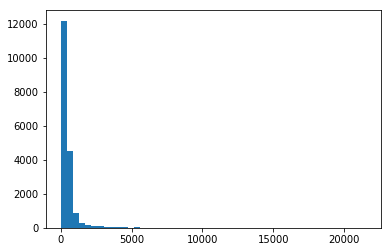

In [0]:
n_bins = 3
fig, axs = plt.subplots(1)
x = df_recipes.calories

# We can set the number of bins with the `bins` kwarg
axs.hist(x, bins=50)

In [0]:
# Later: consider dropping all recipes where calories is a large number.

# Pickle subset

In [0]:
import pickle
with open('gf_recipe_data.pkl', 'wb') as f:
    data = pickle.dump(df_recipes, f)
  